In [2]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import plotly.express as px

from datetime import datetime
from IPython.display import Image

In [3]:
warnings.filterwarnings("ignore")

# Overview

This Exploratory Data Analysis will focus on obtaining insights of high-value loyal customers i.e. customers that make large purchases and repeated orders while using Olist. 

The data cleaning process is elaborated more in the annex's preliminary _data_analysis notebook. Refer to it for more information of how it is cleaned.

**Driving Questions**: 
- Who are the customers returning to Olist?
- What do returning customers depend on Olist for? 
- When do customers return to Olist for products?
- Where do returning customers reside?
- Why do returning customers favour Olist?

# Assumptions
The assumptions made in this EDA.

1) The cities in the customers dataset is the correct spelling and the zip codes, cities and states correctly correspond to one another.
2) Customers who have made more than 1 order on Olist has done so because they are loyal appreciated the service/value Olist provided and not due to other factors, such as sudden sales.
3) Customers who have higher average spending on Olist have greater disposable income.
4) Review scores accurately represent the customers' satisfaction with the order.

# Data Loading
Load the datasets using pandas

In [4]:
# Load the customers dataset
customers_df = pd.read_csv(
    "./data/02_processed/cleaned_customers_dataset.csv",
    converters={
        'customer_zip_code_prefix': str # Convert ZIP codes to strings
    }
)
# Load the geolocation dataset
geolocation_df = pd.read_csv(
    "./data/02_processed/cleaned_geolocation_dataset.csv",
    converters={
        'geolocation_zip_code_prefix': str # Convert ZIP codes to strings
    }
)
# Load the order items dataset
items_df = pd.read_csv("./data/01_raw/olist_order_items_dataset.csv")

# Load the payments dataset
payments_df = pd.read_csv("./data/01_raw/olist_order_payments_dataset.csv")

# Load the reviews dataset
reviews_df = pd.read_csv("./data/02_processed/cleaned_order_reviews_dataset.csv")

# Load the orders dataset
orders_df = pd.read_csv("./data/02_processed/cleaned_orders_dataset.csv")

# Load the products dataset
products_df = pd.read_csv("./data/02_processed/cleaned_products_dataset.csv")

# Load the sellers dataset
sellers_df = pd.read_csv(
    "./data/02_processed/cleaned_sellers_dataset.csv",
    converters={
        'seller_zip_code_prefix': str # Convert ZIP codes to strings
    }
)
# Load the product category name translation dataset
translations_df = pd.read_csv("./data/01_raw/product_category_name_translation.csv")

# Preprocessing
Describes the upstream data cleaning procedures for the data used in this EDA.

**Customers**
- Remove apostrophes from the cities to standardize the city names.

**Items**
- No need for cleaning.

**Geolocations**
- Drop duplicate rows. 98.10% of the rows are duplicate.
- Drop the entries with erroneous latitude and longitude i.e. latitudes and longitudes that exist outside of Brazil. There are 42 entries with erroneous lat and lng values.
- Aggregate the latitude and longitude data of the geolocations dataset by zip code.
- Standardize the spellings of the cities, converting diacritics to standard alphabet as diacritics are used.
- Correct encoding or other errors in the city names by cross-referencing with the customers dataset. There are erroneous characters such as superscripts and symbols.

**Products**
- Drop rows of products with almost completely missing information of the product i.e. rows with null in all columns except product_id. These rows do not provide information of products and thus should be dropped. 2 rows have no information of the product exccept for the product id.
- Impute missing entries in the products dataset using iterative imputing as they are only a small proportion of the dataset. Imputing them fills in the NaN values and ensures the other fields can be used. 1.85% of the entries have at least 1 null value. These can be imputed.

**Orders**
- Drop the order_approved_at and order_delivered_carrier_date fields as they are not useful for determining if the customers will make repeat purchases.
- Drop the erroneous orders which are declared delivered but do not have a date. There are 2 occurences.

**Reviews**
- Drop the fields 'review_comment_title' and 'review_comment_message' fields as they contain a significant proportion of missing values (88.34% and 58.70% respectively).

**Payments**
- Drop payment sequential column as its not a feature that will be needed for customer return.

**Sellers**
- Standardize the spellings of the cities, converting diacritics to standard alphabet as diacritics are used.
- Correct encoding or other errors in the city names by cross-referencing with the customers dataset.

**Translations**
- No need for cleaning.

# Returning Customer Rate
Measure Olist's customer retention.

In [5]:
# Identify the number of orders by each customer
customer_order_count = customers_df['customer_unique_id'].value_counts()

# Create a boolean series for customers who have more than 1 order
repeated_customers = customer_order_count > 1

# Label customers with more than 1 order as a returning customer in a Dataframe
repeated_customers_df = pd.DataFrame({
    'order_count': customer_order_count,
    'is_repeated_customer': repeated_customers
}).reset_index()

# Calculate the number of returning customers
repeated_customers_count = repeated_customers_df['is_repeated_customer'].sum()
print(f"Number of returning customers: {repeated_customers_count}")

# Calculate the proportion of repeated and non-repeated customers
repeated_customers_proportion = repeated_customers_df['is_repeated_customer'].value_counts(normalize=True) * 100

# Reset index to make it a DataFrame
repeated_customers_proportion_df = repeated_customers_proportion.reset_index()
repeated_customers_proportion_df.columns = ['is_repeated_customer', 'proportion']

# Round the proportions to 2dp
repeated_customers_proportion_df['proportion'] = round(repeated_customers_proportion_df['proportion'], 2)

Number of returning customers: 2997


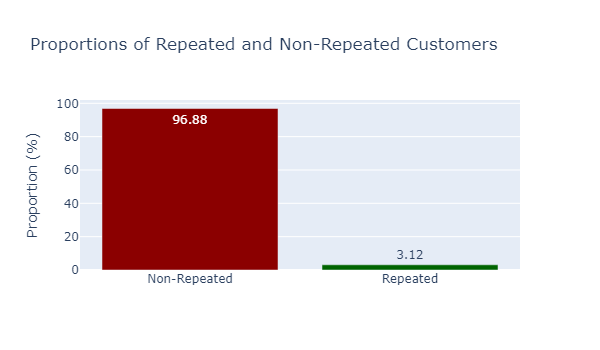

In [6]:
# Create a bar graph to showcase the proportions
fig = px.bar(
    repeated_customers_proportion_df,
    x='is_repeated_customer',
    y='proportion',
    text='proportion',
    color='is_repeated_customer',
    labels={'proportion': 'Proportion (%)'},
    title='Proportions of Repeated and Non-Repeated Customers',
    color_discrete_map={False: 'darkred', True: 'darkgreen'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],
        title=None  # Hide the x-axis title
    ),
    showlegend=False  # Hide the legend
)

# Show the plot
image_bytes = fig.to_image(format='png', width=600, height=350)
Image(image_bytes)

**Findings**:
- Only 2997 of the 96096 customers from 2016 to 2018, are repeated customers. 
- This is only about 3.12% of the total customers from 2016 to 2018.
- This proportion is very small and the insights obtained will be prone to noise in the dataset.

# Delivery Efficiency
Investigates if delivery efficiency contributes to customers returning to Olist.

In [7]:
# Identify the offset between 2 dates
def date_difference(row: pd.Series, start: str, end:str) -> int:
    """
    Calculate the difference in days between two dates.
    """
    try:
        # Identify the 2 dates
        date1 = row[start]
        date2 = row[end]
        # Check if there are any missing dates
        if pd.isna(date1) or pd.isna(date2):
            return None # Returns None when its not delivered yet
        
        # Parse the dates
        d1 = datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
        d2 = datetime.strptime(date2, '%Y-%m-%d %H:%M:%S')

        # Calculate the difference
        day_difference = (d2 - d1).days
        return day_difference
    
    except ValueError as ve:
        raise ValueError(f"Invalid date or format: {ve}")

In [8]:
# Merge the customers dataset with the orders dataset
customer_orders_df = pd.merge(customers_df, orders_df, on='customer_id', how='left')

# Drop the rows with missing delivery and estimated delivery dates 
customer_orders_df.dropna(
    subset=['order_estimated_delivery_date', 'order_delivered_customer_date'],
    axis=0, 
    inplace=True)

# Identify the offset between delivery and estimated delivery
customer_orders_df['delivery_offset'] = customer_orders_df.apply(
    lambda row: date_difference(
        row, 
        'order_estimated_delivery_date', 
        'order_delivered_customer_date'
    ), 
    axis=1
)

customer_orders_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delivery_offset
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,2017-06-05 00:00:00,-11
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,2018-02-06 00:00:00,-8
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,2018-06-13 00:00:00,1


In [ ]:
# Identify the distribution of delivery offset using a histogram
fig = px.histogram(
    customer_orders_df,
    x='delivery_offset',
    nbins=100,
    title='Histogram of Delivery Offset',
    labels={
        'count': 'Frequency',
        'delivery_offset': 'Delivery Offset'
    }
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800, height=300)
Image(image_bytes)

Notes:
- Outliers will need to be dropped in the delivery offset as there are outliers which are delivered very late and very early, up to 40 days late or 50 days early. Outliers need to be removed in analysis.
- Normal distribution
- Most customers experience delivers about 10 days early.

In [10]:
# Initialise the DataFrame to investigate delivery offset
delivery_offset_df = customer_orders_df.copy()

# Merge with repeated customers dataset to identify repeated customers
delivery_offset_df = pd.merge(
    delivery_offset_df, 
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left')

# Calculate IQR for the delivery_offset column
Q1 = delivery_offset_df['delivery_offset'].quantile(0.25)
Q3 = delivery_offset_df['delivery_offset'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
delivery_offset_df = delivery_offset_df[
    (delivery_offset_df['delivery_offset'] >= lower_bound) &
    (delivery_offset_df['delivery_offset'] <= upper_bound)
]

delivery_offset_df.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delivery_offset,is_repeated_customer
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-25 10:35:35,2017-06-05 00:00:00,-11,False
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-29 12:41:19,2018-02-06 00:00:00,-8,False
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-06-14 17:58:51,2018-06-13 00:00:00,1,False


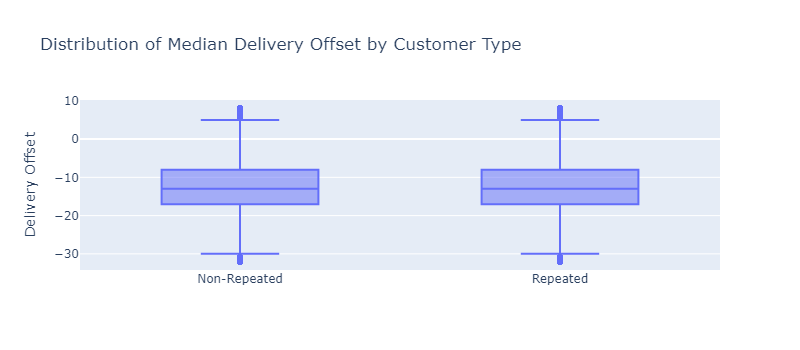

In [11]:
# Create a box plot to show distributions of median delivery offset
fig = px.box(
    delivery_offset_df, 
    x='is_repeated_customer', 
    y='delivery_offset', 
    title='Distribution of Median Delivery Offset by Customer Type',
    labels={'delivery_offset': 'Delivery Offset'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800, height=350)
Image(image_bytes)

**Findings**:
- Both repeated and non-repeated customers have similar distributions of delivery offsets.
- This suggests that the delivery offset, which indicates how early or late a delivery is, does not significantly influence a customer's likelihood of making a repeat purchase on Olist.
- Surprisingly, this means the efficiency of Olist's delivery process is not a factor that contributes to customers making repeated purchases on Olist.

# Product Pricing
Investigates if customers return for cheap or expensive products.

In [12]:
# Merge customers, orders, and products dataset
customer_orders_products_df = (
    customers_df[['customer_id', 'customer_unique_id']]
    .merge(
        orders_df[['customer_id', 'order_id']], 
        on='customer_id', 
        how='left'
    )
    .merge(
        items_df, 
        on='order_id', 
        how='left'
    )
)

# Drop orders with missing items
customer_orders_products_df.dropna(
    axis=0, 
    inplace=True
)

# Initialise the dataframe for investigating product costs
product_costs_df = customer_orders_products_df.copy()

# Calculate total cost of the order
product_costs_df['total_cost'] = product_costs_df['price'] + product_costs_df['freight_value']

# Identify the repeated and non-repeated customers
product_costs_df = product_costs_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left'
)

# Calculate IQR for the total_cost column
Q1 = product_costs_df['total_cost'].quantile(0.25)
Q3 = product_costs_df['total_cost'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
product_costs_df = product_costs_df[
    (product_costs_df['total_cost'] >= lower_bound) &
    (product_costs_df['total_cost'] <= upper_bound)
]

product_costs_df.head(3)

,customer_id,customer_unique_id,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_cost,is_repeated_customer
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,146.87,False
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,157.73,False
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,173.30,False


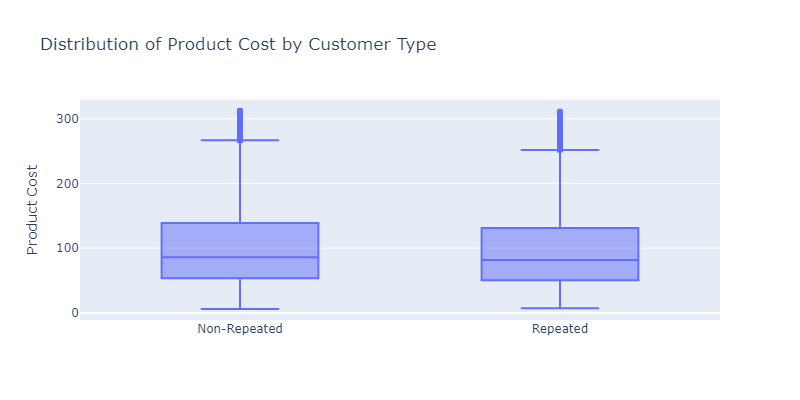

In [13]:
# Create a box plot to show distributions of order_price
fig = px.box(
    product_costs_df, 
    x='is_repeated_customer', 
    y='total_cost', 
    title='Distribution of Product Cost by Customer Type',
    labels={'total_cost': 'Product Cost'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800, height=400)
Image(image_bytes)

**Findings**:
- Both products purchased by repeated and non-repeated customers have similar distributions.
- This implies that the price of the products do not influence repeated customers to make repeated purchases in Olist.

# Item Information
Identify the types or attributes of products that returning customers usually look for, such as small or large products.

## Product Volume

In [14]:
# Merge customers, orders, items, and products
customer_orders_items_products_df = (
    customers_df[['customer_id', 'customer_unique_id']]
    .merge(
        orders_df[['customer_id', 'order_id']], 
        on='customer_id', 
        how='left'
    )
    .merge(
        items_df[['order_id', 'product_id']], 
        on='order_id', 
        how='left'
    )
    .merge(
        products_df, 
        on='product_id', 
        how='left'
    )
)

# Drop rows with missing product information
customer_orders_items_products_df.dropna(
    axis=0, 
    inplace=True
)
# Initialise a DataFrame for investigating volume
volume_df = customer_orders_items_products_df.copy()

# Calculate the volume of the product as a cube
volume_df['volume'] = (
    volume_df['product_length_cm'] *
    volume_df['product_height_cm'] *
    volume_df['product_width_cm']
)

# Identify the repeated and non-repeated customers
volume_df = volume_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']], 
    on='customer_unique_id', 
    how='left'
)

# Calculate IQR for the volume column
Q1 = volume_df['volume'].quantile(0.25)
Q3 = volume_df['volume'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe to remove outliers
volume_df = volume_df[
    (volume_df['volume'] >= lower_bound) &
    (volume_df['volume'] <= upper_bound)
]

volume_df.head(3)

,customer_id,customer_unique_id,order_id,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name,volume,is_repeated_customer
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,9391a573abe00141c56e38d84d7d5b3b,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,casa_conforto,23625.0,False
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,0be701e03657109a8a4d5168122777fb,32.0,282.0,2.0,4450.0,60.0,15.0,15.0,esporte_lazer,13500.0,True
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,36e694cf4cbc2a4803200c35e84abdc4,b5466db4cecf95c3c1be0ba32538ce1a,37.0,322.0,3.0,100.0,16.0,3.0,13.0,informatica_acessorios,624.0,False


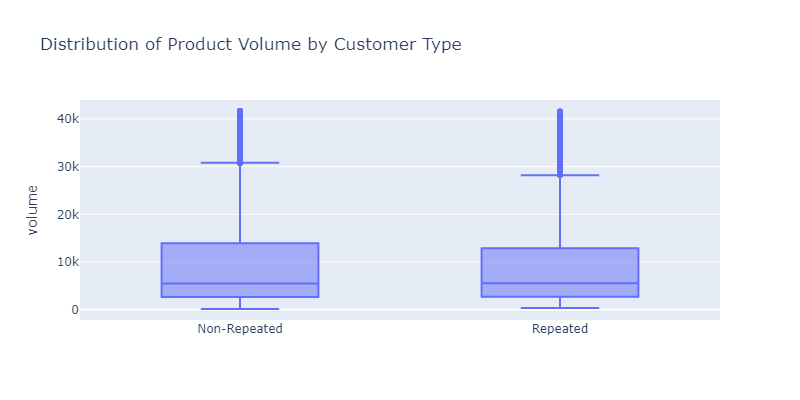

In [15]:
# Create a box plot to show distributions of median_product_description_lenght
fig = px.box(
    volume_df, 
    x='is_repeated_customer', 
    y='volume', 
    title='Distribution of Product Volume by Customer Type'
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800, height=400)
Image(image_bytes)

**Findings**:
  - The volume of the product does not influence repeated customers from making repeat purchases.
  - However, the volume of the product, individually, may not be complete enough to determine if the product's size influences customers making repeat purchases as there is also the factor of product weight.

The dimensions of the product will be kept as there may be a relationship between the volume and weight of the product in influencing customers repeat purchases.

## Product Category

In [16]:
# Merge customer_orders_items_products_df with repeated_customers
product_categories_df = customer_orders_items_products_df.merge(
    repeated_customers_df[['customer_unique_id', 'is_repeated_customer']],
    on='customer_unique_id', 
    how='left'
)

# Remove products which are missing a product category
product_categories_df = product_categories_df[product_categories_df['product_category_name'] != 'missing']

# Aggregate the DataFrame for product_category_name and is_repeated_customer
product_categories_df = product_categories_df.groupby(
    ['is_repeated_customer', 'product_category_name']
).size().reset_index(name='count')

# Calculate proportions
product_categories_df['proportion'] = product_categories_df.groupby(
    'is_repeated_customer'
)['count'].transform(lambda x: round((x / x.sum()) * 100, 2))

# Reset index to convert the Series into a DataFrame
product_categories_df = product_categories_df[['is_repeated_customer', 'product_category_name', 'proportion']]

# Merge with translations to get the english translations of categories
product_categories_df= product_categories_df.merge(
    translations_df,
    on='product_category_name',
    how='left'
)

# Aggregate proportions by product category to determine the top categories
top_categories = (
    product_categories_df.groupby("product_category_name_english")["proportion"]
    .sum()
    .nlargest(10)  # Get the top categories
    .index
)

# Filter the DataFrame to only include the top categories
top_product_categories_df = product_categories_df[
    product_categories_df["product_category_name_english"].isin(top_categories)
]

# Sort the filtered DataFrame by proportion in descending order
top_product_categories_df = top_product_categories_df.sort_values(by='proportion', ascending=False)

# Maps is_repeated_customer values from False to Non-Repeated Customer and True to Repeated Customer
top_product_categories_df['is_repeated_customer'] = top_product_categories_df['is_repeated_customer'].apply(
    lambda x: 'Repeated Customer' if x else 'Non-Repeated Customer'
)

top_product_categories_df.head(3)

,is_repeated_customer,product_category_name,proportion,product_category_name_english
86,Repeated Customer,cama_mesa_banho,14.91,bed_bath_table
125,Repeated Customer,moveis_decoracao,10.99,furniture_decor
13,Non-Repeated Customer,cama_mesa_banho,9.66,bed_bath_table


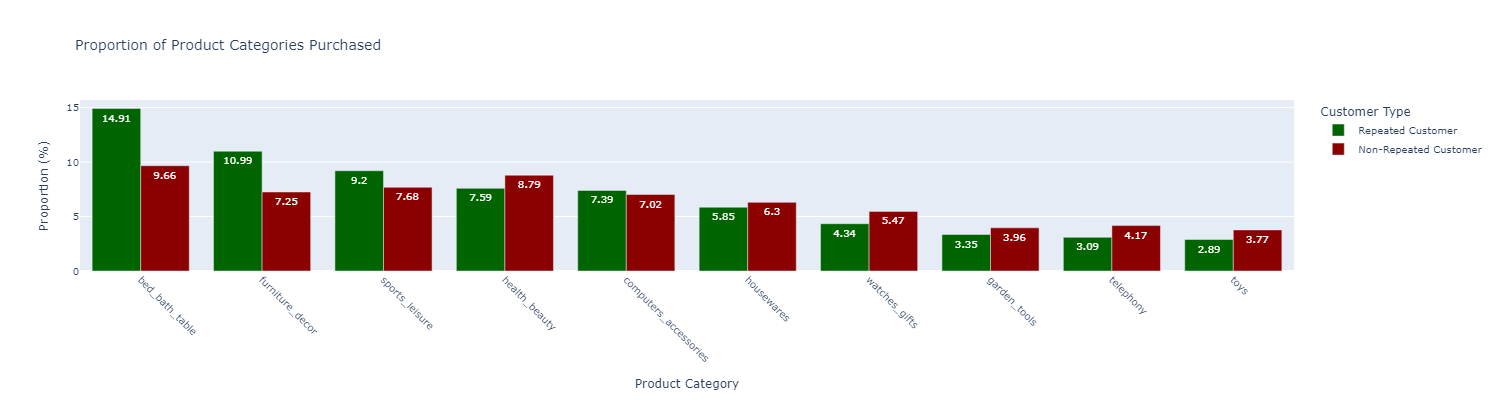

In [17]:
# Plot side-by-side bar graphs
fig = px.bar(
    top_product_categories_df,
    x="product_category_name_english",
    y="proportion",
    text="proportion",
    color="is_repeated_customer",
    barmode="group",  # Ensures bars are placed side by side
    labels={'proportion': 'Proportion (%)'},
    title="Proportion of Product Categories Purchased",
    color_discrete_map={
        'Non-Repeated Customer': 'darkred', 
        'Repeated Customer': 'darkgreen'
    }
)

# Modify layout
fig.update_layout(
    xaxis_title="Product Category",
    yaxis_title="Proportion (%)",
    legend_title="Customer Type",
    xaxis_tickangle=45,  # Rotate x-axis labels for better visibility
    font=dict(size=10) 
)


# Show the plot
image_bytes = fig.to_image(format='png', width=1500, height=400)
Image(image_bytes)

**Findings**:
- Repeated customers buy 5% more products from the bed_bath_table and  3% more products from the furniture_decor category in Olist, as compared to non-repeated customers.
- This implies that Repeated Customers favour Olist for providing products related to:
  - bed_bath_table
  -  furniture_decor
-  This feature will be useful for the modeling process and included in feature selection.



# Customer Satisfaction
Investigate if there is a correlation between customer satisfaction and returning customer rate.

In [18]:
# Aggregate reviews by order id to determine their overall satisfaction with the order
agg_reviews_df = reviews_df.groupby('order_id').agg(
    {
        'review_id': 'first',
        'review_score': 'mean'
    }
).reset_index()
agg_reviews_df.head(3)

,order_id,review_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,97ca439bc427b48bc1cd7177abe71365,5.0
1,00018f77f2f0320c557190d7a144bdd3,7b07bacd811c4117b742569b04ce3580,4.0
2,000229ec398224ef6ca0657da4fc703e,0c5b33dea94867d1ac402749e5438e8b,5.0


In [19]:
# Merge customers, orders, the aggregated reviews, and the repeated customers
customers_orders_reviews_df = (
    customers_df[['customer_id', 'customer_unique_id']]
    .merge(
        orders_df[['customer_id', 'order_id']], 
        on='customer_id', 
        how='left'
    )
    .merge(
        agg_reviews_df, 
        on='order_id', 
        how='left'
    )
    .merge(
        repeated_customers_df, 
        on='customer_unique_id', 
        how='left'
    )
)

# Drop rows with missing reviews and scores
customers_orders_reviews_df.dropna(
    subset=['review_id', 'review_score'],
    axis=0, 
    inplace=True
)

customers_orders_reviews_df.head(3)

,customer_id,customer_unique_id,order_id,review_id,review_score,order_count,is_repeated_customer
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,88b8b52d46df026a9d1ad2136a59b30b,4.0,1,False
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,1,False
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,5ad6695d76ee186dc473c42706984d87,5.0,1,False


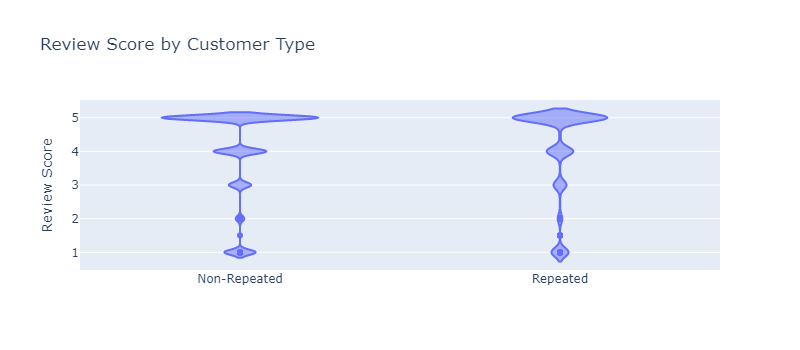

In [20]:
# Create a violin plot to showcase distribution of product count per order
fig = px.violin(
    customers_orders_reviews_df, 
    x='is_repeated_customer', 
    y='review_score', 
    title='Review Score by Customer Type',
    labels={'review_score': 'Review Score'}
)

# Hide the x-axis and change the category names
fig.update_layout(
    xaxis=dict(
        tickvals=[0, 1],  # Set custom tick values 
        ticktext=['Non-Repeated', 'Repeated'],  # Custom category names
        title=None  # Hide the x-axis title
    )
)

# Show the plot
image_bytes = fig.to_image(format='png', width=800, height=350)
Image(image_bytes)

**Findings**:
- Generally, the distribution of review score of both repeated and non-repeated customers is similar.
- Non-repeated customers seems to have significantly more reviews with review scores of 5 than repeat customers.
- This implies that review scores is not important in determining repeated customer.
- However, it will still be kept in feature selection as it may have relationship with product information to determine if the customer will repeat purchase. 

# Location
Compare the locations of high-value customers to other customers. Identifies the demographic of people who are more likely to buy from Olist.

In [21]:
# Merge the customers and geolocations dataset
customers_geolocations_df = (
    customers_df[['customer_unique_id', 'customer_zip_code_prefix']]
    .merge(
        geolocation_df,
        how='left',
        left_on='customer_zip_code_prefix',
        right_on='geolocation_zip_code_prefix'
    )
    .merge(
        repeated_customers_df[['customer_unique_id', 'is_repeated_customer']],
        how='left',
        on='customer_unique_id'
    )
)

# Drop missing geolocations
customers_geolocations_df.dropna(
    subset=['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state'],
    axis=0, 
    inplace=True
)

customers_geolocations_df.head(3)

,customer_unique_id,customer_zip_code_prefix,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,is_repeated_customer
0,861eff4711a542e4b93843c6dd7febb0,14409,14409,-20.502307,-47.396740,franca,SP,False
1,290c77bc529b7ac935b93aa66c333dc3,09790,09790,-23.730435,-46.541474,sao bernardo do campo,SP,False
2,060e732b5b29e8181a18229c7b0b2b5e,01151,01151,-23.531294,-46.656980,sao paulo,SP,False


Findings:
- Customers mostly reside along the coastline of Brazil and in the southern cities of sao paulo and rio de janeiro.
- Compared to non-repeated customers, repeated customers seem to be sparsely distributed in the northern cities of Brazil.
- Olist should market their products and ecommerce website in the southern cities of Brazil.

In [23]:
# Initialise a DataFrame to investigate the cities
cities_df = customers_geolocations_df.copy()

# Aggregate the DataFrame for geolocation_city and is_repeated_customer
cities_df = cities_df.groupby(
    ['is_repeated_customer', 'geolocation_city']
).size().reset_index(name='count')

# Calculate proportions
cities_df['proportion'] = cities_df.groupby(
    'is_repeated_customer'
)['count'].transform(lambda x: round((x / x.sum()) * 100, 2))

# Reset index to convert the Series into a DataFrame
cities_df = cities_df[['is_repeated_customer', 'geolocation_city', 'proportion']]

# Aggregate proportions by city to determine the top cities
top_cities = (
    cities_df.groupby("geolocation_city")["proportion"]
    .sum()
    .nlargest(10)  # Get the top categories
    .index
)

# Filter the DataFrame to only include the top cities
top_cities_df = cities_df[
    cities_df["geolocation_city"].isin(top_cities)
]

# Sort the filtered DataFrame by proportion in descending order
top_cities_df = top_cities_df.sort_values(by='proportion', ascending=False)

# Maps is_repeated_customer values from False to Non-Repeated Customer and True to Repeated Customer
top_cities_df['is_repeated_customer'] = top_cities_df['is_repeated_customer'].apply(
    lambda x: 'Repeated Customer' if x else 'Non-Repeated Customer'
)

top_cities_df.head(3)

,is_repeated_customer,geolocation_city,proportion
4732,Repeated Customer,sao paulo,17.14
3510,Non-Repeated Customer,sao paulo,15.57
4646,Repeated Customer,rio de janeiro,8.06


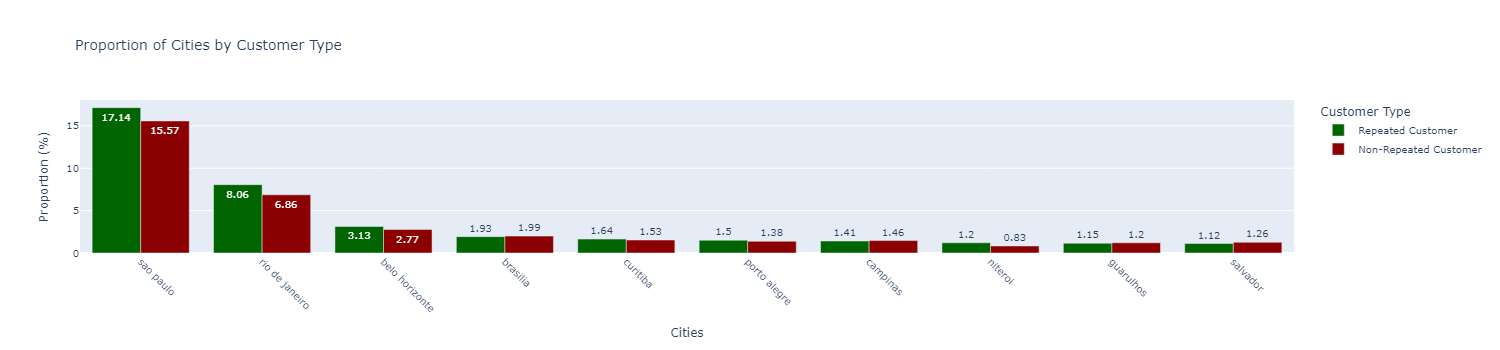

In [24]:
# Plot side-by-side bar graphs
fig = px.bar(
    top_cities_df,
    x="geolocation_city",
    y="proportion",
    text="proportion",
    color="is_repeated_customer",
    barmode="group",  # Ensures bars are placed side by side
    labels={'proportion': 'Proportion (%)'},
    title="Proportion of Cities by Customer Type",
    color_discrete_map={
        'Non-Repeated Customer': 'darkred', 
        'Repeated Customer': 'darkgreen'
    }
)

# Modify layout
fig.update_layout(
    xaxis_title="Cities",
    yaxis_title="Proportion (%)",
    legend_title="Customer Type",
    xaxis_tickangle=45,  # Rotate x-axis labels for better visibility
    font=dict(size=10) 
)


# Show the plot
image_bytes = fig.to_image(format='png', width=1500, height=350)
Image(image_bytes)

**Findings**:
- The bar chart above shows that the distribution of cities in the geolocations dataset is generally even for both repeated and non-repeated customers.
- The even distribution suggests that residents living in different most cities do not have a preference or significant difference in their likelihood to make repeat purchases with Olist.
- However, notably, there is a slightly higher proportion of repeat customers residing in sao paulo and rio de janerio as compared to non-repeat customers (1%).
- This could suggest that sao paulo and rio de janerio residents have a higher demand for products offered by Olist, making them more likely to return and make repeat purchases.
- It could also suggest that sao paulo and rio de janerio residents are more likely to appreciate Olist's services over other ecommerce websites.
- To increase Returning Customer Rate and loyalty to Olist, Olist can increase marketing efforts in the cities of sao paulo and rio de janeiro